<a href="https://colab.research.google.com/github/prakrut12/Wine-Classifier/blob/main/Wine_Quality_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# (Optional) If you also want XGBoost:
!pip -q install xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import joblib

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False


In [2]:
data = load_wine(as_frame=True)
df = data.frame.copy()   # includes features + target
df.rename(columns={'target': 'class'}, inplace=True)

print(df.shape)
df.head()


(178, 14)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [3]:
print(df['class'].value_counts())
df.describe().T


class
1    71
0    59
2    48
Name: count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


In [4]:
X = df.drop(columns=['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((142, 13), (36, 13))

Baseline (LogReg) Accuracy: 0.9722222222222222
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        12
           1      0.933     1.000     0.966        14
           2      1.000     0.900     0.947        10

    accuracy                          0.972        36
   macro avg      0.978     0.967     0.971        36
weighted avg      0.974     0.972     0.972        36



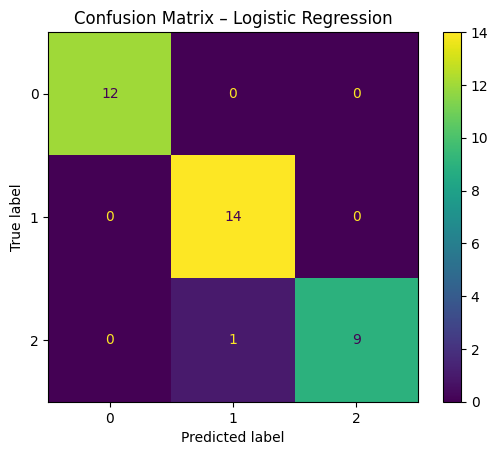

In [5]:
pipe_log = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=2000))
])

pipe_log.fit(X_train, y_train)
y_pred = pipe_log.predict(X_test)
print("Baseline (LogReg) Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix – Logistic Regression")
plt.show()


In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "SVM_RBF": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='rbf', probability=True))
    ]),
    "kNN": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier())
    ]),
    "RandomForest": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(random_state=42))
    ]),
}

if HAS_XGB:
    models["XGBoost"] = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', XGBClassifier(
            random_state=42, eval_metric='mlogloss', use_label_encoder=False
        ))
    ])

for name, pipe in models.items():
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"{name:12s} CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


SVM_RBF      CV Accuracy: 0.9833 ± 0.0222
kNN          CV Accuracy: 0.9717 ± 0.0181
RandomForest CV Accuracy: 0.9775 ± 0.0213
XGBoost      CV Accuracy: 0.9662 ± 0.0281


a) SVM (usually 97–100% on Wine)


Best SVM params: {'clf__C': 2, 'clf__gamma': 'scale'}
SVM Test Accuracy: 0.9722222222222222
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        12
           1      0.933     1.000     0.966        14
           2      1.000     0.900     0.947        10

    accuracy                          0.972        36
   macro avg      0.978     0.967     0.971        36
weighted avg      0.974     0.972     0.972        36



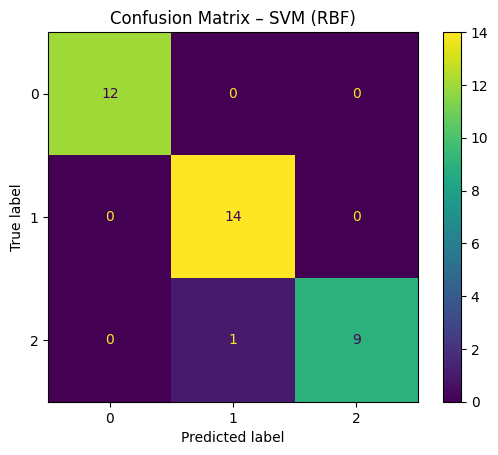

In [9]:
param_svm = {
    'clf__C': [0.5, 1, 2, 5, 10],
    'clf__gamma': ['scale', 0.1, 0.05, 0.01]
}
svm_pipe = models["SVM_RBF"]

gs_svm = GridSearchCV(
    svm_pipe, param_svm, scoring='accuracy', cv=cv, n_jobs=-1
)
gs_svm.fit(X_train, y_train)

print("Best SVM params:", gs_svm.best_params_)
y_pred = gs_svm.predict(X_test)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix – SVM (RBF)")
plt.show()


b) Random Forest

Best RF params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
RF Test Accuracy: 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        12
           1      1.000     1.000     1.000        14
           2      1.000     1.000     1.000        10

    accuracy                          1.000        36
   macro avg      1.000     1.000     1.000        36
weighted avg      1.000     1.000     1.000        36



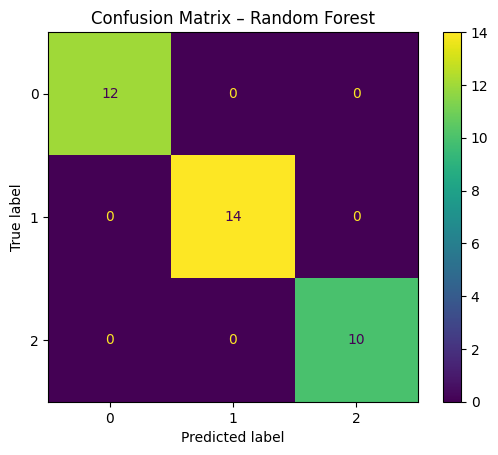

In [10]:
param_rf = {
    'clf__n_estimators': [200, 400, 600],
    'clf__max_depth': [None, 5, 8],
    'clf__min_samples_split': [2, 4],
}
rf_pipe = models["RandomForest"]

gs_rf = GridSearchCV(
    rf_pipe, param_rf, scoring='accuracy', cv=cv, n_jobs=-1
)
gs_rf.fit(X_train, y_train)

print("Best RF params:", gs_rf.best_params_)
y_pred = gs_rf.predict(X_test)
print("RF Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix – Random Forest")
plt.show()


c)XGBoost

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:18:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB params: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__subsample': 0.9}
XGB Test Accuracy: 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        12
           1      1.000     1.000     1.000        14
           2      1.000     1.000     1.000        10

    accuracy                          1.000        36
   macro avg      1.000     1.000     1.000        36
weighted avg      1.000     1.000     1.000        36



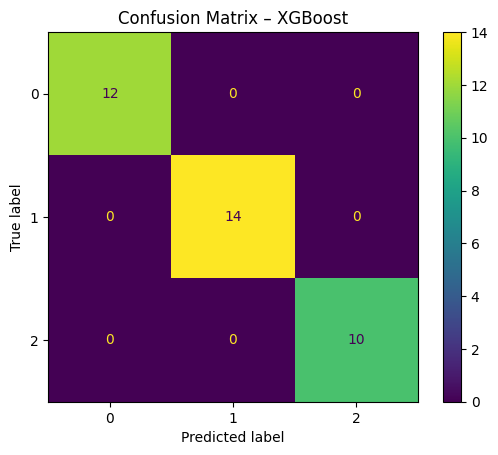

In [11]:
if HAS_XGB:
    param_xgb = {
        'clf__n_estimators': [200, 400, 600],
        'clf__max_depth': [3, 5],
        'clf__learning_rate': [0.05, 0.1],
        'clf__subsample': [0.9, 1.0],
        'clf__colsample_bytree': [0.8, 1.0],
    }
    xgb_pipe = models["XGBoost"]

    gs_xgb = GridSearchCV(
        xgb_pipe, param_xgb, scoring='accuracy', cv=cv, n_jobs=-1
    )
    gs_xgb.fit(X_train, y_train)

    print("Best XGB params:", gs_xgb.best_params_)
    y_pred = gs_xgb.predict(X_test)
    print("XGB Test Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=3))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title("Confusion Matrix – XGBoost")
    plt.show()


Feature Importance / Interpretability

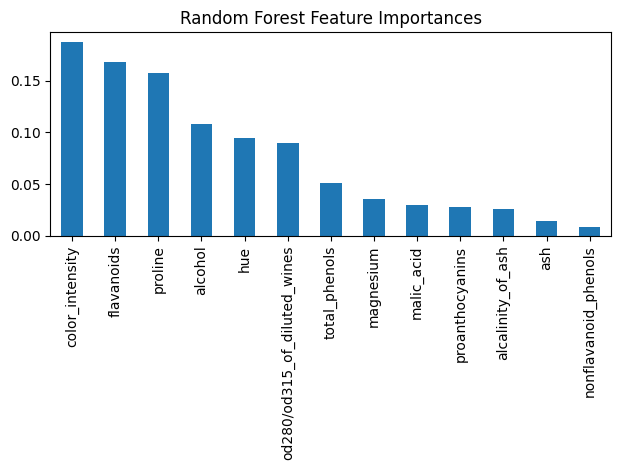

In [12]:
best_rf = gs_rf.best_estimator_
rf = best_rf.named_steps['clf']
importances = rf.feature_importances_
feat_names = X.columns

imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
imp.head(10)
imp.plot(kind='bar')
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


Save the Best Model (for reuse)

In [14]:
# Choose the best performing model among gs_svm / gs_rf / gs_xgb (if used)
best_estimator = gs_svm if 'gs_svm' in globals() else gs_rf
joblib.dump(best_estimator.best_estimator_, 'wine_best_model.joblib')

# Download (Colab)
from google.colab import files
files.download('wine_best_model.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Single-Row Prediction Demo

In [15]:
row = X_test.iloc[[0]].copy()
print("True class:", int(y_test.iloc[0]))

pred = best_estimator.predict(row)[0]
proba = (best_estimator.predict_proba(row)[0]).round(3)
print("Predicted class:", int(pred))
print("Class probabilities:", proba)


True class: 0
Predicted class: 0
Class probabilities: [0.987 0.006 0.007]


Tiny Gradio App (nice for demos)

In [16]:
!pip -q install gradio

import gradio as gr

clf = best_estimator

def predict_gradio(**kwargs):
    row = pd.DataFrame([kwargs])
    pred = int(clf.predict(row)[0])
    proba = clf.predict_proba(row)[0]
    return {f"class_{i}": float(p) for i, p in enumerate(proba)}, pred

inputs = []
for col in X.columns:
    # numeric sliders with simple ranges based on data
    min_v = float(X[col].min()); max_v = float(X[col].max())
    step = (max_v - min_v) / 100 if max_v > min_v else 0.1
    inputs.append(gr.Slider(minimum=min_v, maximum=max_v, value=float(X[col].mean()), step=step, label=col))

demo = gr.Interface(
    fn=lambda *vals: predict_gradio(**dict(zip(X.columns, vals))),
    inputs=inputs,
    outputs=[gr.Label(num_top_classes=3, label="Probabilities"), gr.Number(label="Predicted Class")],
    title="Wine Classifier (UCI)",
    description="Adjust features and see predicted wine class."
)
demo.launch(share=False)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>